In [59]:
import math
import numpy as np
import random
import decimal
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import os
import pandas as pd

#Now to implement q learning and variants on the above market environment
import sys
if "../" not in sys.path:
  sys.path.append("../") 

#from lib.utes import run_experiment, plot_values, plot_greedy_policy, \
#                        plot_action_values, random_policy, plot_state_value

#from lib.envs.grid import Grid, FeatureGrid, AltGrid
#from TD import  GeneralQ, ExperienceQ, DynaQ #, FeatureExperienceQ, FeatureDynaQ
#from FA.model import TabularModel #, LinearModel
#from Tabular import ExpTabAgent

from lib.envs.market import Market
from lib.envs.market2 import Market2
from lib.envs.market_sp500 import Market_sp500

from lib.graphs import make_baseline_graphs, make_agent_graphs,plot_sample_paths,plot_disc_utility,plot_mv_equiv,plot_const_step, plot_mv_equivs, make_agent_graphs_ex3
    
from lib.sim_prices import make_prices, run_stepsim_fixedprop
from lib.sim_prices2 import make_prices2, run_stepsim_fixedprop
from lib.execute_strat import execute_strat
from lib.execute_strat2 import execute_strat2
from lib.execute_strat2 import execute_strat_sp500

import importlib
from pandas_datareader import data as wb


import warnings
warnings.filterwarnings("ignore")

from statistics import mean
from statistics import stdev

%matplotlib inline

In [60]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
mu =0.122 #save these paramters mu 0.11, rf 0.10, sigma 0.028
rf = 0.0477
M = 250 #so 20 time periods or 50 still works...just longer to train and run, u_star = np.linspace(-10,25, utes)

time_periods = M
T = 1.0
dt = T/M
utes = 21
#u_star = np.linspace(-10,25, utes) #this is specific to the above parameters

kappa = 0.007


#We will always start with a stock price of 1, bond price of 1, and a time period which will be subdivided
#wealth starts at 100
S0 = 1
B0 = 1
X0 = 100
wealth = X0


u_star = np.linspace(0,5, utes)
sigma = 0.1698

    
   #################################################
# Stage 1 of my stuff is simply get a merton ration and sample paths 
# the maths (using stochastic optimal control will be described in the thesis)

#Set parameters
mu =0.05
rf = 0.04
sigma = 0.028
M = 250
time_periods = M
T = 1.0
dt = T/M
utes = 15
u_star = np.linspace(-10,25, utes) #this is specific to the above parameters

#We will always start with a stock price of 1, bond price of 1, and a time period which will be subdivided
#wealth starts at 100
S0 = 1
B0 = 1
X0 = 100
wealth = X0
kappa = 0.007 
#The merton ratio leads to a constant ratio for GBM log utility
#note this is a very high leverage because of the low vol
#I did this due to difficulties getting RL to learn anything 
#and we can play around with how to solve this

merton_ratio = (mu-rf)/sigma**2
merton_ratio #the ratio to invest

merton_value = np.log(X0) + (rf + ((mu-rf)/2*sigma**2))

print(merton_ratio, merton_value)
num_sims =30000
S, B, utility, means, variances = make_prices(mu, sigma, rf, utes, time_periods, dt, X0, B0,S0, u_star, num_sims)

#if we know the answer is log utility and 
#we know that we have gbm then we can simulate to
#see if our best action is close to the optimal ratio
#according to merton's formula

#we need this to compare the merton strategy to our learned agent
best_action = np.argmax(utility)
utility[best_action]
u_star[best_action] #12.5 is the closest we have to merton which is 12.7
#Ritters paper looks at mean variance equivalence distributions
#he can thus convert with a parameter kappa the above utility to 
#a mean variance trade off...this is possible for all mean variance equiv distn
#and upward sloping utility function (of which log is)

def mv_equiv(kappa, mean, variance):
    return mean - (kappa/2)*variance

merton_ratio = (mu-rf)/sigma**2
best_action = np.argmin(np.abs(u_star-merton_ratio))
print(best_action)
print(u_star[best_action])
u_star

12.755102040816327 4.645174105988092
29.389436911028284
40.58264294324263
55.79090136274651
76.36217462899799
104.06442577901814
81.32628174793668
63.26042521394362
48.97662509346464
37.73838885500198
28.93989630089163
22.08565104995494
16.77268818032102
12.675148453706122
9.531013099079246
7.130786219087205
9
12.5


array([-10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,  10. ,
        12.5,  15. ,  17.5,  20. ,  22.5,  25. ])

12.755102040816327 4.645174105988092
55.79090136274651
73.03329486784716
95.29879356723751
90.44112217534679
73.06737660997852
58.828296416918654
47.200144324995236
37.73838885500198
30.067310643789096
23.87067928787633
18.883444612201362
14.884378155863972
11.689595484615023
9.146887242594309
7.130786219087205
8
12.142857142857142


array([-5.        , -2.85714286, -0.71428571,  1.42857143,  3.57142857,
        5.71428571,  7.85714286, 10.        , 12.14285714, 14.28571429,
       16.42857143, 18.57142857, 20.71428571, 22.85714286, 25.        ])

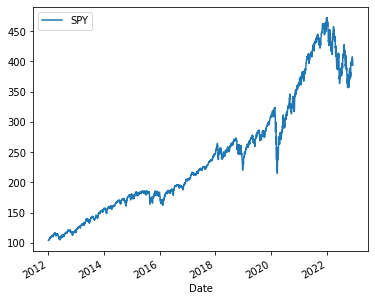

In [252]:
ticker = 'SPY'
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source = 'yahoo', start = '2012-1-1')['Adj Close']
log_returns = np.log(1 + data.pct_change())
#Plot
data.plot(figsize=(6,5))
u = log_returns.mean()
sp500_mu=float(u*250)
sp500_sigma=float(np.sqrt(np.var(log_returns*np.sqrt(250))))
#Set parameters
mu =sp500_mu
mu=0.05
rf = 0.0477
rf=0.04
sigma = sp500_sigma
sigma=0.028
M = 250
time_periods = M
T = 1.0
dt = T/M
utes = 15 #choose 21 to get nice round leverage ratios
u_star = np.linspace(0,5, utes) #this is specific to the above parameters
u_star = np.linspace(-5,25, utes)
#We will always start with a stock price of 1, bond price of 1, and a time period which will be subdivided
#wealth starts at 100
S0 = 1
B0 = 1
X0 = 100
wealth = X0
kappa = 0.005

merton_ratio = (mu-rf)/sigma**2
merton_ratio #the ratio to invest

merton_value = np.log(X0) + (rf + ((mu-rf)/2*sigma**2))

print(merton_ratio, merton_value)
num_sims =30000
S, B, utility, means, variances = make_prices(mu, sigma, rf, utes, time_periods, dt, X0, B0,S0, u_star, num_sims)

#if we know the answer is log utility and 
#we know that we have gbm then we can simulate to
#see if our best action is close to the optimal ratio
#according to merton's formula

#we need this to compare the merton strategy to our learned agent
best_action = np.argmax(utility)
utility[best_action]
u_star[best_action] #12.5 is the closest we have to merton which is 12.7
#Ritters paper looks at mean variance equivalence distributions
#he can thus convert with a parameter kappa the above utility to 
#a mean variance trade off...this is possible for all mean variance equiv distn
#and upward sloping utility function (of which log is)

def mv_equiv(kappa, mean, variance):
    return mean - (kappa/2)*variance

merton_ratio = (mu-rf)/sigma**2
best_action = np.argmin(np.abs(u_star-merton_ratio))
print(best_action)
print(u_star[best_action])
u_star


In [121]:
kappa=0.008
vals = mv_equiv(kappa, means, variances)

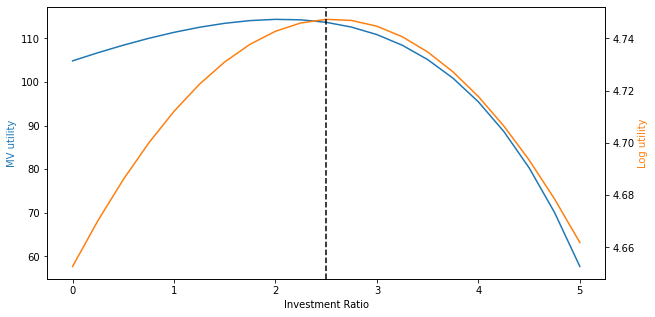

In [122]:
#figure for chapter 5.2: experiment 1
x=u_star
y1=vals
y2=utility
fig, ax1=plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(x, y1, 'tab:blue')
ax2.plot(x, y2, 'tab:orange')

ax1.set_xlabel('Investment Ratio')
ax1.set_ylabel("MV utility", color='tab:blue')
ax2.set_ylabel('Log utility', color='tab:orange')
#fig.suptitle('Mean-variance and log utility')
plt.axvline(x = 2.5, color = 'black', linestyle='--' )
plt.show()

In [3]:
num_sims =30000
S, B, utility, means, variances = make_prices(mu, sigma, rf, utes, time_periods, dt, X0, B0,S0, u_star, num_sims)

#if we know the answer is log utility and 
#we know that we have gbm then we can simulate to
#see if our best action is close to the optimal ratio
#according to merton's formula

#we need this to compare the merton strategy to our learned agent
best_action = np.argmax(utility)
utility[best_action]
u_star[best_action] #12.5 is the closest we have to merton which is 12.7

29.389436911028284
40.58264294324263
55.79090136274651
76.36217462899799
104.06442577901814
81.32628174793668
63.26042521394362
48.97662509346464
37.73838885500198
28.93989630089163
22.08565104995494
16.77268818032102
12.675148453706122
9.531013099079246
7.130786219087205


12.5

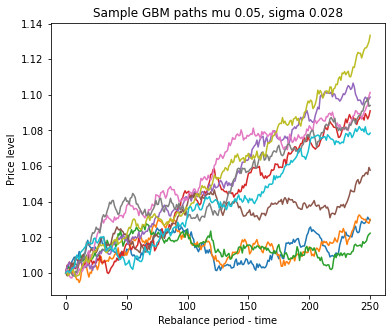

In [12]:
plt.rcParams["figure.figsize"] = (6,5)
plot_sample_paths(S, mu, sigma)

In [17]:
#figure for chapter 5.2: experiment 1
x=u_star
y1=vals
y2=utility
fig, ax1=plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Investment Ratio')
ax1.set_ylabel("Mean-kappa/2*variance", color='g')
ax2.set_ylabel('Log Utility', color='b')
fig.suptitle('Mean-variance and log utility')

plt.show()

NameError: name 'vals' is not defined

In [4]:
#####be sure to calibrate kappa in the same way as the training for the agent

#run the various baseline graphs pre agent
utilities_test_rand, rewards_test_rand, step_rew_rand, wealth_test_rand = execute_strat(kappa,mu, rf, sigma, utes,u_star,best_action, 'Random', 
                                                                      time_periods=time_periods, wealth=wealth, episodes=100001)
utilities_test_best, rewards_test_best, step_rew_best, wealth_test_best = execute_strat(kappa, mu, rf, sigma, utes, u_star, best_action,'Merton', 
                                                                      time_periods=time_periods, wealth=wealth, episodes=100001)

#block_utilities_test_rand = np.mean(np.array(utilities_test_rand).reshape(1000,-1),0)
#block_utilities_test_best = np.mean(np.array(utilities_test_best).reshape(1000,-1),0)

# Experiment 4: compare to merton

In [67]:
#Now with the trained agent
plt.rcParams["figure.figsize"] = (6,5)
path=os.getcwd()
files = os.listdir(path+'/experiment_4_1/')

results = []


for file in files:
    print(file)

    Q = np.load(path+'/experiment_4_1/'+file)
    utilities_test, rewards_test, step_rew_test, wealth_test = execute_strat(kappa, mu, rf, sigma, utes, 
                                    u_star,best_action, 'Agent', q_values=Q, 
                                    time_periods=time_periods, wealth=wealth, episodes=100001)

2epi200001kap7.0egr0.04776652504901985gam0.9.npy


2epi200001kap7.0egr0.04776652504901985gam0.9.npy


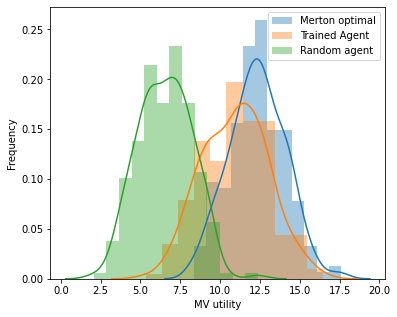

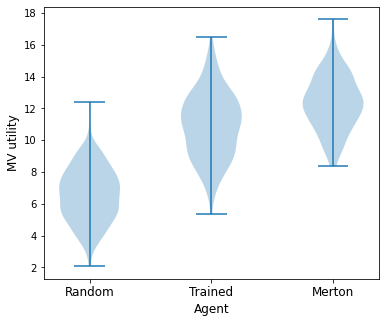

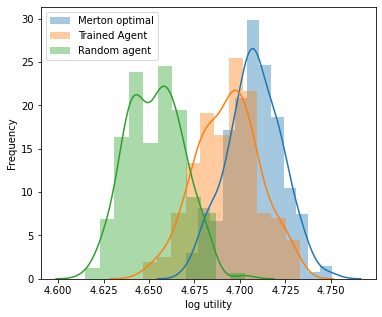

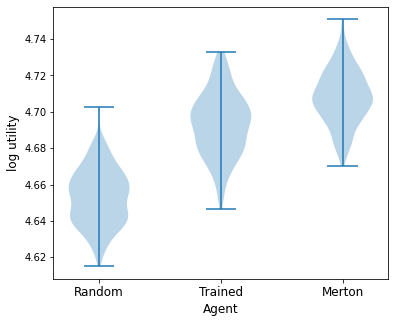

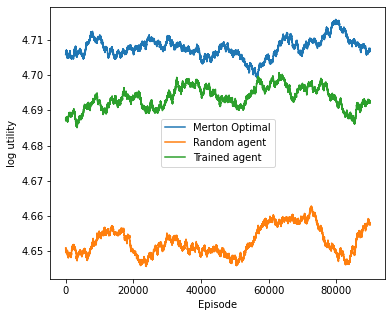

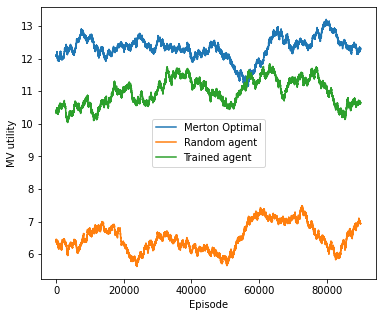

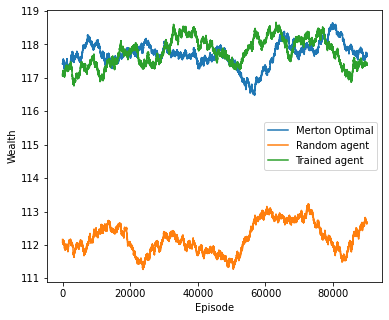

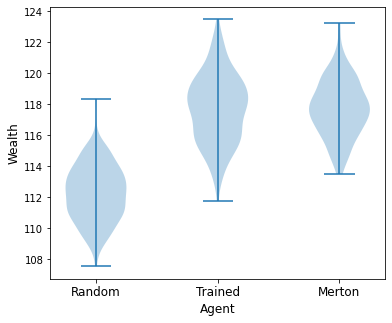

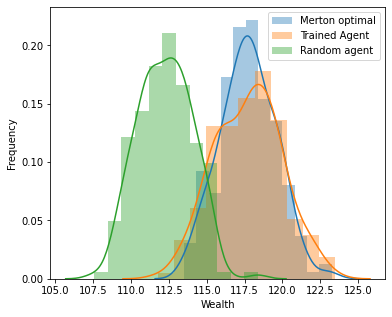

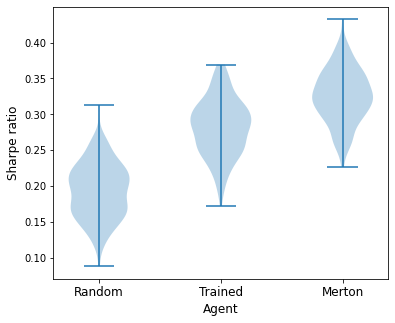

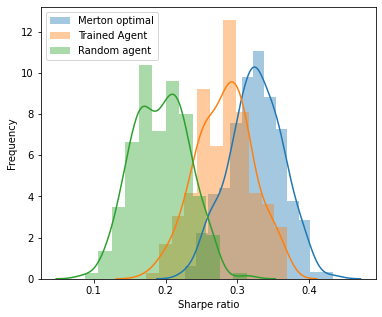

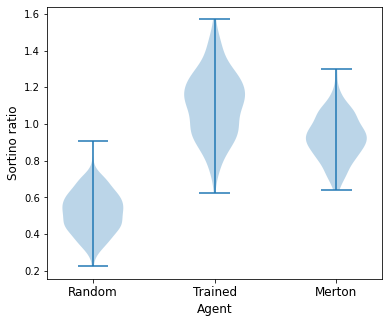

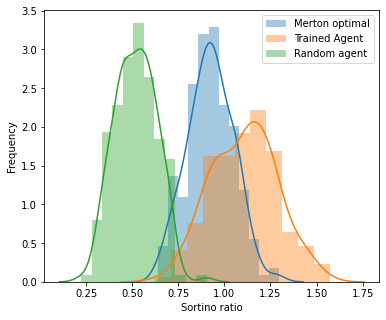

In [70]:
results = []


for file in files:
    print(file)

    res = make_agent_graphs_ex3(rewards_test_best, rewards_test_rand, rewards_test,
            utilities_test_best, utilities_test_rand, utilities_test,
            wealth_test_rand, wealth_test_best, wealth_test,
            step_rew_best, step_rew_rand, step_rew_test,
            rf)
    results.append(res)

# Tables for ex 4

In [94]:
log_util_rand = mean(utilities_test_rand)
mv_util_rand = mean(rewards_test_rand)
wealth_rand = mean(wealth_test_rand)
excess_ret_rand = mean(wealth_test_rand)-100-100*rf
std_wealth = stdev(wealth_test_best)
neg_std_wealth = stdev(list(filter(lambda x: x<0, [x-100-rf*100 for x in wealth_test_rand])))

rand_log_list=['Random',
log_util_rand, 
mv_util_rand, 
100*excess_ret_rand/std_wealth,
100*excess_ret_rand/neg_std_wealth,
wealth_rand]

log_util_best = mean(utilities_test_best)
mv_util_best = mean(rewards_test_best)
wealth_best = mean(wealth_test_best)
excess_ret_best = mean(wealth_test_best)-100-100*rf
std_wealth = stdev(wealth_test_best)
neg_std_wealth = stdev(list(filter(lambda x: x<0, [x-100-rf*100 for x in wealth_test_best])))

best_log_list=['Merton',
log_util_best, 
mv_util_best, 
100*excess_ret_best/std_wealth,
100*excess_ret_best/neg_std_wealth,
wealth_best]

model_results=pd.DataFrame({'model':['Q-learning']})

avg_list=[]
mv_util=[]
avg_step_list=[]
std_step_list=[]    
sharpe_list=[]
sortino_list=[]
negative_std_step_list=[]
wealth_list=[]

#sns.distplot(np.mean(np.array(all_models[i][4]).reshape(500,-1),0), label=file)
avg_list.append(mean(utilities_test))
mv_util.append(mean(rewards_test))
#avg_step_list.append(mean(step_rew_test))
#std_step_list.append(stdev(all_models_1[i][2]))
#negative_std_step_list.append(stdev(list(filter(lambda x: x < 0, all_models_1[i][2]))))
sharpe_list.append(100*mean([x-100-rf*100 for x in wealth_test])/stdev(wealth_test))
wealth_list.append(mean(wealth_test))
sortino_list.append(100*mean([x-100-rf*100 for x in wealth_test])/stdev(list(filter(lambda x: x < 0, [x-100-rf*100 for x in wealth_test]))))
#plt.legend()
#plt.show()
model_results['log utility']=avg_list
model_results['MV utility']=mv_util
#model_results['Sharpe']=[x-100/y for x,y in zip(avg_step_list,std_step_list)]
#model_results['Sortino']=[x/y for x,y in zip(avg_step_list,negative_std_step_list)]
model_results['Sharpe']=sharpe_list
model_results['Sortino']=sortino_list
model_results['Wealth']=wealth_list
#model_results.loc[0]=rand_log_list
#model_results.loc[1]=best_log_list
model_results
#model_results.set_index('model').round(3).to_latex()

model_results.loc[1] = rand_log_list
model_results.loc[2] = best_log_list
print(model_results.round(3).to_latex())

# Experiment 5

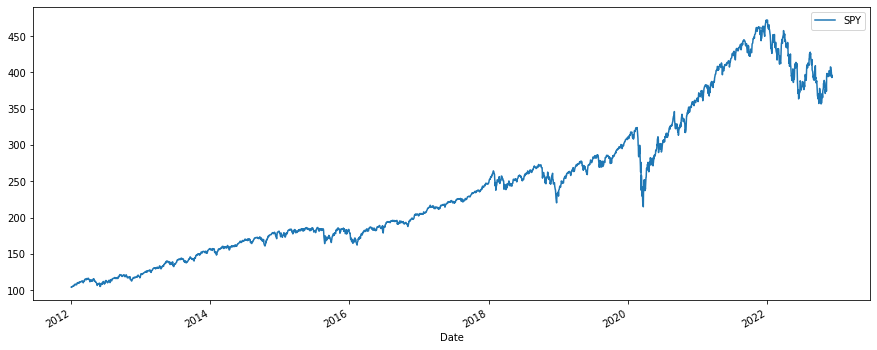

In [97]:
import pandas as pd
from pandas_datareader import data as wb
from scipy.stats import norm

ticker = 'SPY'
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source = 'yahoo', start = '2012-1-1')['Adj Close']
#Plot
data.plot(figsize=(15,6))
log_returns = np.log(1 + data.pct_change())
u = log_returns.mean()
sp500_mu=float(u*250)
sp500_sigma=float(np.sqrt(np.var(log_returns*np.sqrt(250))))

# create index 1

In [98]:
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source = 'yahoo', start = '2020-1-1', end='2020-12-31')['Adj Close']
data.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=253, freq=None)

In [99]:
#Set parameters
mu =sp500_mu
rf = 0.0477
sigma = sp500_sigma
M = 250
time_periods = M
T = 1.0
dt = T/M
utes = 21 #choose 21 to get nice round leverage ratios
u_star = np.linspace(0,5, utes) #this is specific to the above parameters

#We will always start with a stock price of 1, bond price of 1, and a time period which will be subdivided
#wealth starts at 100
S0 = 1
B0 = 1
X0 = 100
wealth = X0
kappa = 0.007

In [100]:
num_sims =30000
S, B, utility, means, variances = make_prices(mu, sigma, rf, utes, time_periods, dt, X0, B0,S0, u_star, num_sims)

104.86558487107264
90.61388671892956
78.16618568781801
67.3134649595534
57.86823237576028
49.6626632148303
42.5468567036675
36.38720541232931
31.064875703211793
26.474396582708916
22.52235362159531
19.12618405953403
16.213068777725606
13.718916500361468
11.587435358955883
9.769286812827973
8.221316853407831
6.905859419590268
5.790107006559514
4.845543552509609
4.047434828303467


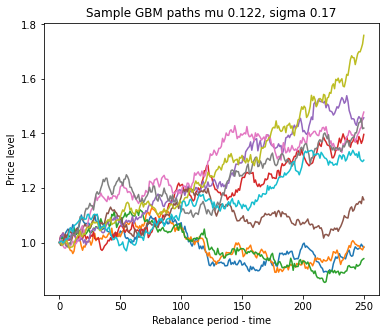

In [101]:
plt.rcParams["figure.figsize"] = (6,5)
plot_sample_paths(S, 0.122, 0.170)

In [102]:
merton_ratio = (mu-rf)/sigma**2
merton_ratio #the ratio to invest

merton_value = np.log(X0) + (rf + ((mu-rf)/2*sigma**2))

print(merton_ratio, merton_value)
def mv_equiv(kappa, mean, variance):
    return mean - (kappa/2)*variance

merton_ratio = (mu-rf)/sigma**2
best_action = np.argmin(np.abs(u_star-merton_ratio))
#Run a reward step by step simulation with fixed investment levels to check this looks
#similar to the utility set up

episodes = 200000
kappa = 0.005
mean_rewards, mean_utes, all_wealth = run_stepsim_fixedprop(kappa, mu, sigma, rf,
                                                            u_star, Market, wealth, episodes=2000, time_periods=250)

2.5313465768352885 4.653923551507026
Inv ratio:  0.0 Mean log utility:  4.652679385988103
Inv ratio:  0.0 Mean Reward:  4.865347136446047
Min wealth:  104.86558487107264 Max Wealth:  104.86558487107264
Inv ratio:  0.25 Mean log utility:  4.671024476811701
Inv ratio:  0.25 Mean Reward:  6.85291385891773
Min wealth:  93.98599835713844 Max Wealth:  125.06415819661446
Inv ratio:  0.5 Mean log utility:  4.685068284833299
Inv ratio:  0.5 Mean Reward:  8.507682979381524
Min wealth:  82.92444061644825 Max Wealth:  139.4932357976883
Inv ratio:  0.75 Mean log utility:  4.698563091579166
Inv ratio:  0.75 Mean Reward:  10.223804972208322
Min wealth:  74.33323971634518 Max Wealth:  169.99886659146387
Inv ratio:  1.0 Mean log utility:  4.709662956627737
Inv ratio:  1.0 Mean Reward:  11.833960518024766
Min wealth:  61.86534470697422 Max Wealth:  187.2858377932997
Inv ratio:  1.25 Mean log utility:  4.718843540760532
Inv ratio:  1.25 Mean Reward:  13.2441303832151
Min wealth:  58.737681647877125 Max W

In [103]:
# 6 minutes for 100,000 episodes
# 13 minutes 200,000
#kappa = 0.006

#run the various baseline graphs pre agent
utilities_test_rand, rewards_test_rand, step_rew_rand, wealth_test_rand = execute_strat2(kappa,mu, rf, sigma, utes,u_star,best_action, 'Random', 
                                                                      time_periods=time_periods, wealth=wealth, episodes=100001)
utilities_test_best, rewards_test_best, step_rew_best, wealth_test_best = execute_strat2(kappa, mu, rf, sigma, utes, u_star, best_action,'Merton', 
                                                                      time_periods=time_periods, wealth=wealth, episodes=100001)

#block_utilities_test_rand = np.mean(np.array(utilities_test_rand).reshape(1000,-1),0)
#block_utilities_test_best = np.mean(np.array(utilities_test_best).reshape(1000,-1),0)

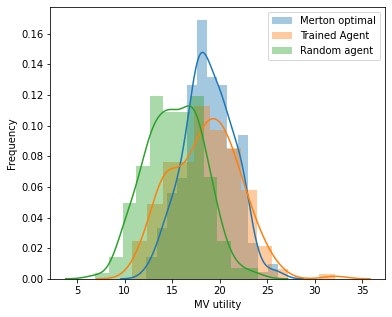

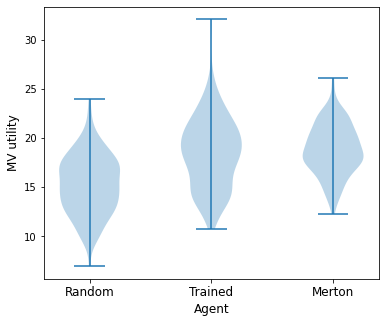

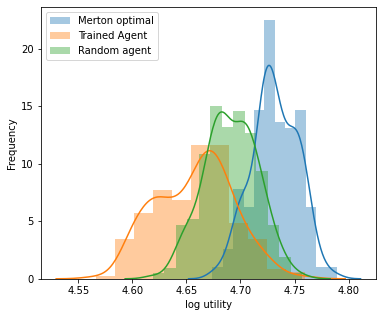

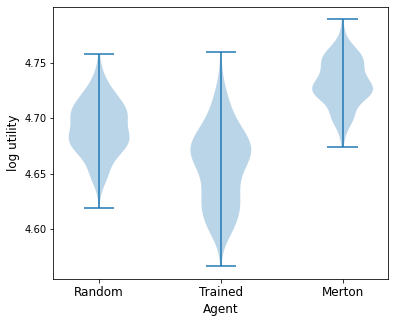

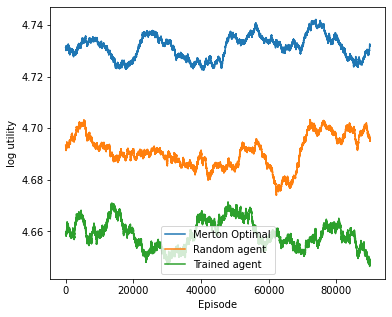

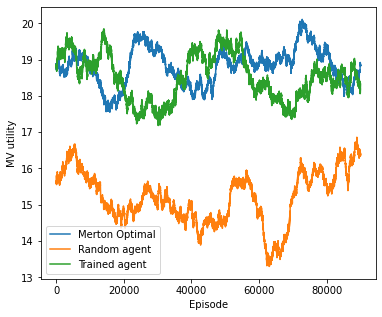

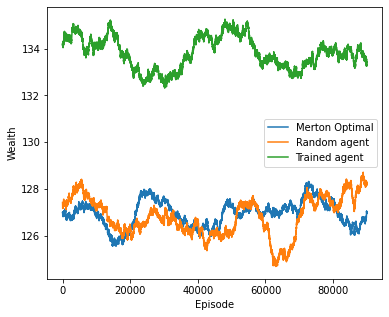

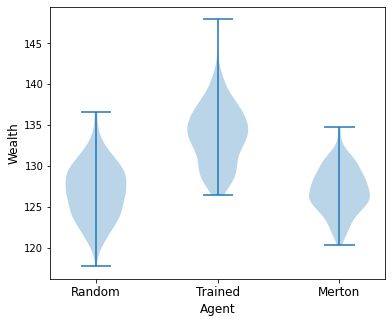

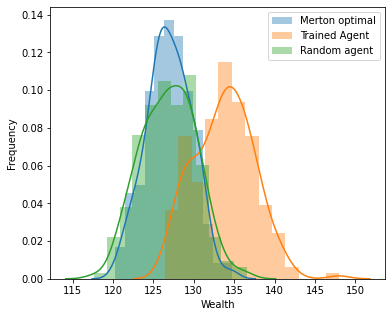

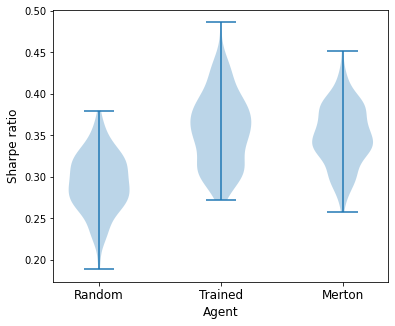

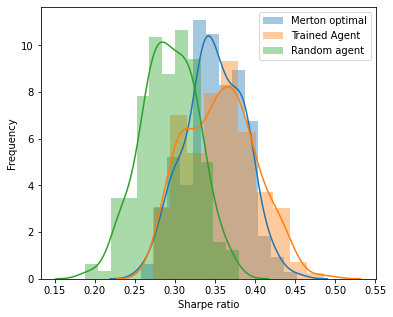

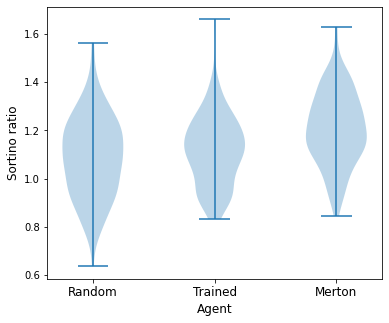

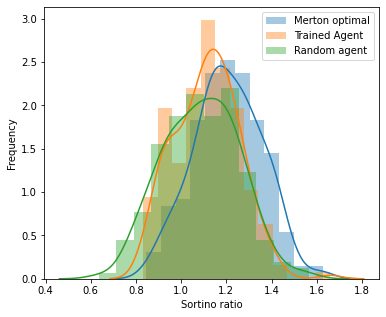

In [104]:
#Now with the trained agent
plt.rcParams["figure.figsize"] = (6,5)
path=os.getcwd()
files = os.listdir(path+'/experiment_5_9/')

results = []
kappa=0.005
for file in files:
    Q = np.load(path+'/experiment_5_9/'+file)
    utilities_test, rewards_test, step_rew_test, wealth_test = execute_strat2(kappa, mu, rf, sigma, utes, 
                                    u_star,best_action, 'Agent', q_values=Q, 
                                    time_periods=time_periods, wealth=wealth, episodes=100001)
    res=make_agent_graphs_ex3(rewards_test_best, rewards_test_rand, rewards_test,
        utilities_test_best, utilities_test_rand, utilities_test,
        wealth_test_rand, wealth_test_best, wealth_test,
        step_rew_best, step_rew_rand, step_rew_test,
        rf)
    results.append(res)

In [105]:
log_util_rand = mean(utilities_test_rand)
mv_util_rand = mean(rewards_test_rand)
wealth_rand = mean(wealth_test_rand)
excess_ret_rand = mean(wealth_test_rand)-100-100*rf
std_wealth = stdev(wealth_test_rand)
neg_std_wealth = stdev(list(filter(lambda x: x<0, [x-100-rf*100 for x in wealth_test_rand])))

rand_log_list=['Random',
log_util_rand, 
mv_util_rand, 
100*excess_ret_rand/std_wealth,
100*excess_ret_rand/neg_std_wealth,
wealth_rand]

log_util_best = mean(utilities_test_best)
mv_util_best = mean(rewards_test_best)
wealth_best = mean(wealth_test_best)
excess_ret_best = mean(wealth_test_best)-100-100*rf
std_wealth = stdev(wealth_test_best)
neg_std_wealth = stdev(list(filter(lambda x: x<0, [x-100-rf*100 for x in wealth_test_best])))

best_log_list=['Merton',
log_util_best, 
mv_util_best, 
100*excess_ret_best/std_wealth,
100*excess_ret_best/neg_std_wealth,
wealth_best]

model_results=pd.DataFrame({'model':['Q-learning']})

avg_list=[]
mv_util=[]
avg_step_list=[]
std_step_list=[]    
sharpe_list=[]
sortino_list=[]
negative_std_step_list=[]
wealth_list=[]

#sns.distplot(np.mean(np.array(all_models[i][4]).reshape(500,-1),0), label=file)
avg_list.append(mean(utilities_test))
mv_util.append(mean(rewards_test))
#avg_step_list.append(mean(step_rew_test))
#std_step_list.append(stdev(all_models_1[i][2]))
#negative_std_step_list.append(stdev(list(filter(lambda x: x < 0, all_models_1[i][2]))))
sharpe_list.append(100*mean([x-100-rf*100 for x in wealth_test])/stdev(wealth_test))
wealth_list.append(mean(wealth_test))
sortino_list.append(100*mean([x-100-rf*100 for x in wealth_test])/stdev(list(filter(lambda x: x < 0, [x-100-rf*100 for x in wealth_test]))))
#plt.legend()
#plt.show()
model_results['log utility']=avg_list
model_results['MV utility']=mv_util
#model_results['Sharpe']=[x-100/y for x,y in zip(avg_step_list,std_step_list)]
#model_results['Sortino']=[x/y for x,y in zip(avg_step_list,negative_std_step_list)]
model_results['Sharpe']=sharpe_list
model_results['Sortino']=sortino_list
model_results['Wealth']=wealth_list
#model_results.loc[0]=rand_log_list
#model_results.loc[1]=best_log_list
model_results
#model_results.set_index('model').round(3).to_latex()

model_results.loc[1] = rand_log_list
model_results.loc[2] = best_log_list
print(model_results.round(3).to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &       model &  log utility &  MV utility &  Sharpe &  Sortino &   Wealth \\
\midrule
0 &  Q-learning &        4.658 &      18.442 &  35.573 &  111.364 &  133.738 \\
1 &      Random &        4.691 &      15.260 &  34.768 &  108.795 &  126.889 \\
2 &      Merton &        4.732 &      18.832 &  34.883 &  120.692 &  126.962 \\
\bottomrule
\end{tabular}



# S&P 500

In [375]:
import datetime as dt
import matplotlib.dates as mdates

In [27]:
path=os.getcwd()
files = os.listdir(path+'/experiment_5_6/')

results = []


for file in files:
    print(file)

    Q = np.load(path+'/experiment_5_6/'+file)

In [72]:
def sp500_plt_tabl(start, end, deep_data, ticker='SPY'):
    ut_b,re_b,st_b,we_b,sw_b=execute_strat_sp500(kappa, rf, sigma, utes,u_star,best_action, 'Merton', start=start, end=end, ticker=ticker,q_values=None,
                                                                        wealth=wealth, episodes=2) 
    ut_a,re_a,st_a,we_a,sw_a=execute_strat_sp500(kappa, rf, sigma, utes,u_star,best_action, 'Agent', start=start, end=end, ticker=ticker,q_values=Q,
                                                                        wealth=wealth, episodes=2)
    ut_s,re_s,st_s,we_s,sw_s=execute_strat_sp500(kappa, rf, sigma, utes,u_star,best_action, 'sp500', start=start, end=end,ticker=ticker,q_values=None,
                                                                        wealth=wealth, episodes=2)   
    ut_d,re_d,st_d,we_d,sw_d=deep_data                                                                                                                                                                                                                
                                                                                            
    df=pd.DataFrame([[ut_b,re_b,we_b],[ut_a,re_a,we_a],[ut_s,re_s,we_s], [ut_d,re_d,we_d]], columns=["log utility", "mv utility", "wealth"], index=['Merton','Q-learning','S&P 500','Deep Learning'])
    for i in ["log utility", "mv utility", "wealth"]:
        df[i] = df[i].str[0]   
    df=df.round(3)
    data = pd.DataFrame()
    #ticker='SPY'
    data[ticker] = wb.DataReader(ticker, data_source = 'yahoo', start = start, end=end)['Adj Close']
    dates=data.index.strftime('%Y-%m-%d').tolist()
    x = dates
    #create plot for utility
    cum_best=pd.DataFrame(st_b, index=x).cumsum()
    cum_agent=pd.DataFrame(st_a, index=x).cumsum()
    cum_sp500=pd.DataFrame(st_s, index=x).cumsum()
    cum_deep=pd.DataFrame(st_d, index=x).cumsum()

    #x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
    fig = plt.figure(figsize=(6, 5))
    plt.xticks(rotation=20)
    ax = plt.gca()
    ax.xaxis.set_ticks_position('none') 
    plt.plot(cum_best, label='Merton Optimal')
    plt.plot(cum_agent, label='Q-learning Agent')
    plt.plot(cum_sp500, label=str(ticker))
    plt.plot(cum_deep, label='Deep Learning Agent')
    every_nth = 60
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    plt.ylabel('Episode MV utilities')
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    plt.show()
    #create plot for wealth
    """cumw_best=pd.DataFrame(sw_b, index=x).cumsum()
    cumw_agent=pd.DataFrame(sw_a, index=x).cumsum()
    cumw_sp500=pd.DataFrame(sw_s, index=x).cumsum()
    cumw_deep=pd.DataFrame(sw_d, index=x).cumsum()
    fig = plt.figure(figsize=(6, 5))
    plt.xticks(rotation=20)
    ax = plt.gca()
    ax.xaxis.set_ticks_position('none') 
    plt.plot(cumw_best, label='Merton Optimal')
    plt.plot(cumw_agent, label='Q-learning Agent')
    plt.plot(cumw_sp500, label=str(ticker))
    plt.plot(cumw_deep, label='Deep Learning Agent')
    every_nth = 90
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    plt.ylabel('Episode wealth')
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    plt.show()"""
    print(df.round(3).to_latex())

In [18]:
def execute_strat_sp500(kappa, rf, sigma, utes,u_star,best_action, 
                  policy, start, end, ticker='SPY', q_values=None, episodes=2, wealth=100.0):
    #Execute learned policy
    # compare to random baseline or best
    #import torch
    #this needs a lot of tidying lots of hard coded dependencies on the above
    
    wealth = wealth

    #time_periods = time_periods
    utilities_test = []
    rewards_test = []
    log_rewards_test = []
    step_rewards = []
    step_wealth = []
    rsum = 0
    log_rsum = 0
    wealth_episodes = []
    number_of_actions = utes

    #this needs tidying - specific for problem above
    start_state = int(wealth/10)
    state = start_state 
    
    Mark = Market_sp500(kappa, episodes, rf, sigma, start, end,ticker)

    for i_episode in range(episodes-1):
        state = start_state

        while True:
            #this is for q values using torch
            #random_values = Q[state] + torch.rand(1,number_of_actions) / 1000
            #action = torch.max(random_values,1)[1][0]
            #using my code???
            
            if policy=="Agent":
                #action = np.argmax(agent.q_values[state])
                action = np.argmax(q_values[state])

            elif policy=="Random":
                action = int(torch.LongTensor(1).random_(0, number_of_actions))
            elif policy=="Merton":
                action = best_action
            
            #if loading 
            #action = np.argmax(Q1[state])
            #print(action)

            #new_state, reward, done, info = env.step(action)
            if policy=="sp500":
                prop=1
            else:
                prop = u_star[action]
            reward, log_reward,d, new_state, dx, done = Mark.step((prop, wealth))
            #reward = np.log(dx)                
            #print("reward ",reward)
            #print("dx ",dx)
            #print("wealth", wealth)
            wealth += dx
            new_state = int(wealth/10)

            rsum += reward
            log_rsum+=log_reward
            state = new_state
            
            #step_prop.append(prop)
            step_rewards.append(reward)
            step_wealth.append(dx)

            if done:
                state = start_state
                #print(rsum)
                #print(wealth)
                utilities_test.append(np.log(wealth))
                rewards_test.append(rsum)
                log_rewards_test.append(log_rsum)
                wealth_episodes.append(wealth)
                #mean_prop=mean(step_prop)
                rsum = 0
                log_rsum=0
                wealth = 100.0
                break
                
    return utilities_test, rewards_test, step_rewards, wealth_episodes, step_wealth#, mean_prop #s, step_prop

In [133]:
path=os.getcwd()
files = os.listdir(path+'/experiment_5_6/')
kappa=0.005
results = []


for file in files:
    print(file)

    Q = np.load(path+'/experiment_5_6/'+file)

2epi200001kap14.0egr0.05gam0.9.npy


In [143]:
%store -r period_1
%store -r period_2
%store -r period_3
%store -r period_4
%store -r period_5
%store -r period_6
%store -r d_oney
%store -r d_wip
%store -r d_qqq
%store -r d_dia
%store -r d_vgk

%store -r d_naqdag_list

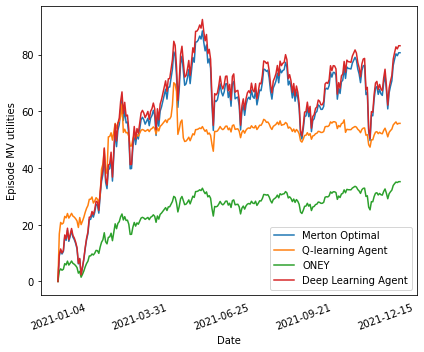

\begin{tabular}{lrrr}
\toprule
{} &  log utility &  mv utility &   wealth \\
\midrule
Merton        &        5.255 &      80.681 &  191.488 \\
Q-learning    &        5.073 &      55.763 &  159.590 \\
S\&P 500       &        4.914 &      35.197 &  136.235 \\
Deep Learning &        5.274 &      83.155 &  195.223 \\
\bottomrule
\end{tabular}



In [134]:
sp500_plt_tabl('2021-01-01','2021-12-31', d_oney, ticker='ONEY')


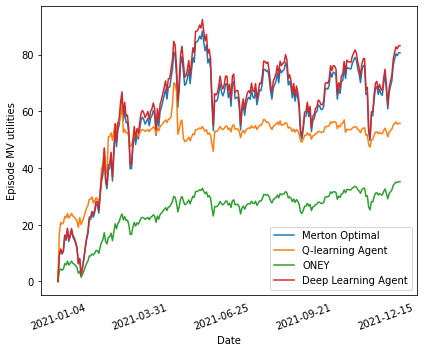

,log utility,mv utility,wealth
Merton,5.255,80.681,191.488
Q-learning,5.073,55.763,159.589
S&P 500,4.914,35.197,136.235
Deep Learning,5.274,83.155,195.223


In [41]:
sp500_plt_tabl('2021-01-01','2021-12-31', d_oney, ticker='ONEY')


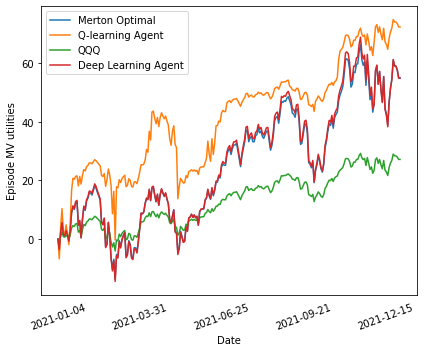

\begin{tabular}{lrrr}
\toprule
{} &  log utility &  mv utility &   wealth \\
\midrule
Merton        &        5.093 &      55.002 &  162.833 \\
Q-learning    &        5.188 &      72.408 &  179.088 \\
S\&P 500       &        4.853 &      27.176 &  128.188 \\
Deep Learning &        5.097 &      54.935 &  163.471 \\
\bottomrule
\end{tabular}



In [135]:
sp500_plt_tabl('2021-01-01','2021-12-31', d_qqq, ticker='QQQ')

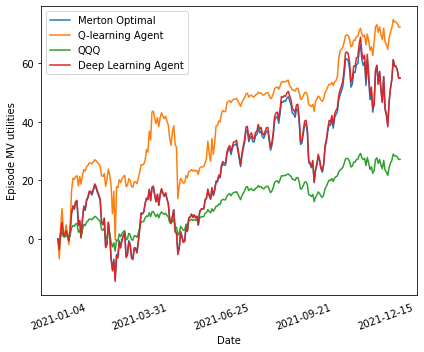

,log utility,mv utility,wealth
Merton,5.093,55.002,162.833
Q-learning,5.188,72.407,179.087
S&P 500,4.853,27.176,128.188
Deep Learning,5.097,54.935,163.471


In [42]:
sp500_plt_tabl('2021-01-01','2021-12-31', d_qqq, ticker='QQQ')

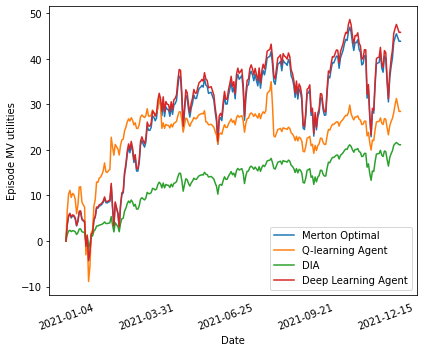

\begin{tabular}{lrrr}
\toprule
{} &  log utility &  mv utility &   wealth \\
\midrule
Merton        &        4.995 &      43.840 &  147.616 \\
Q-learning    &        4.872 &      28.451 &  130.580 \\
S\&P 500       &        4.801 &      21.129 &  121.601 \\
Deep Learning &        5.010 &      45.798 &  149.954 \\
\bottomrule
\end{tabular}



In [136]:
sp500_plt_tabl('2021-01-01','2021-12-31', d_dia, ticker='DIA')

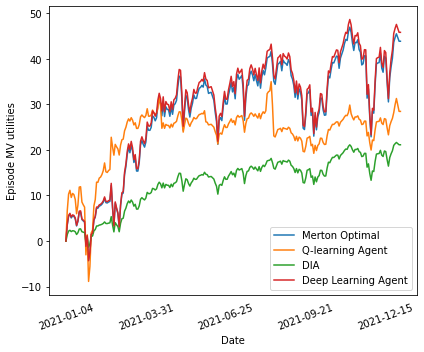

,log utility,mv utility,wealth
Merton,4.995,43.840,147.616
Q-learning,4.872,28.451,130.580
S&P 500,4.801,21.129,121.601
Deep Learning,5.010,45.798,149.954


In [43]:
sp500_plt_tabl('2021-01-01','2021-12-31', d_dia, ticker='DIA')

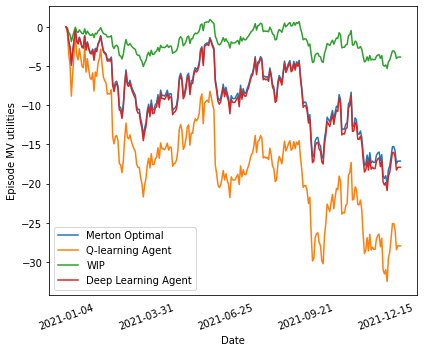

\begin{tabular}{lrrr}
\toprule
{} &  log utility &  mv utility &  wealth \\
\midrule
Merton        &        4.428 &     -17.122 &  83.732 \\
Q-learning    &        4.299 &     -27.940 &  73.631 \\
S\&P 500       &        4.568 &      -3.845 &  96.312 \\
Deep Learning &        4.419 &     -17.922 &  82.993 \\
\bottomrule
\end{tabular}



In [84]:
sp500_plt_tabl('2021-01-01','2021-12-31', d_wip, ticker='WIP')

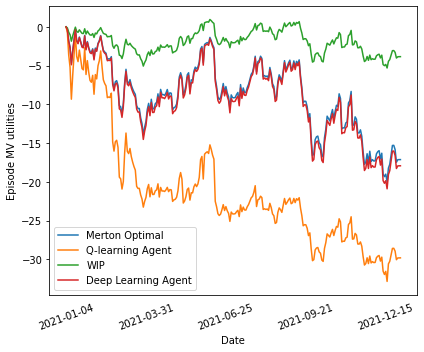

,log utility,mv utility,wealth
Merton,4.428,-17.122,83.732
Q-learning,4.266,-29.796,71.206
S&P 500,4.568,-3.845,96.312
Deep Learning,4.419,-17.922,82.993


In [44]:
sp500_plt_tabl('2021-01-01','2021-12-31', d_wip, ticker='WIP')

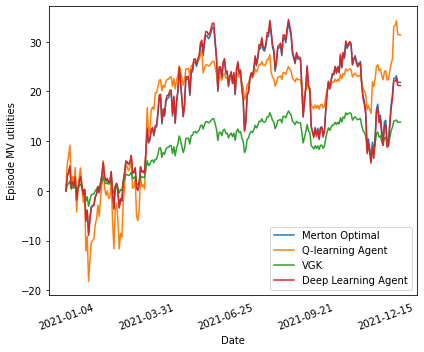

\begin{tabular}{lrrr}
\toprule
{} &  log utility &  mv utility &   wealth \\
\midrule
Merton        &        4.834 &      21.825 &  125.766 \\
Q-learning    &        4.908 &      31.395 &  135.407 \\
S\&P 500       &        4.739 &      13.819 &  114.366 \\
Deep Learning &        4.832 &      21.192 &  125.462 \\
\bottomrule
\end{tabular}



In [137]:
sp500_plt_tabl('2021-01-01','2021-12-31', d_vgk, ticker='VGK')

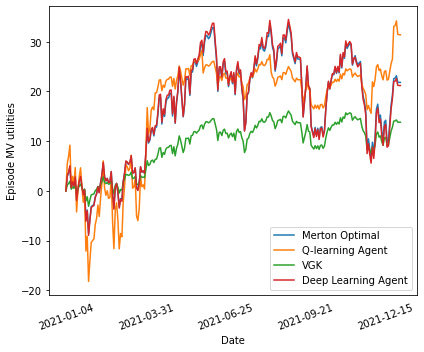

\begin{tabular}{lrrr}
\toprule
{} &  log utility &  mv utility &   wealth \\
\midrule
Merton        &        4.834 &      21.825 &  125.766 \\
Q-learning    &        4.908 &      31.395 &  135.407 \\
S\&P 500       &        4.739 &      13.819 &  114.366 \\
Deep Learning &        4.832 &      21.192 &  125.462 \\
\bottomrule
\end{tabular}



In [79]:
sp500_plt_tabl('2021-01-01','2021-12-31', d_vgk, ticker='VGK')

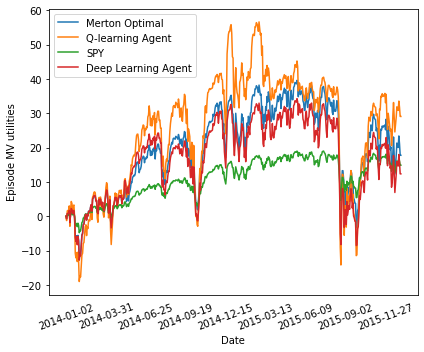

\begin{tabular}{lrrr}
\toprule
{} &  log utility &  mv utility &   wealth \\
\midrule
Merton        &        4.836 &      17.770 &  125.997 \\
Q-learning    &        4.975 &      29.101 &  144.700 \\
S\&P 500       &        4.754 &      14.879 &  115.995 \\
Deep Learning &        4.796 &      12.357 &  121.030 \\
\bottomrule
\end{tabular}



In [86]:
%store -r period_1
sp500_plt_tabl('2014-01-01','2015-12-31', period_1, ticker='SPY')

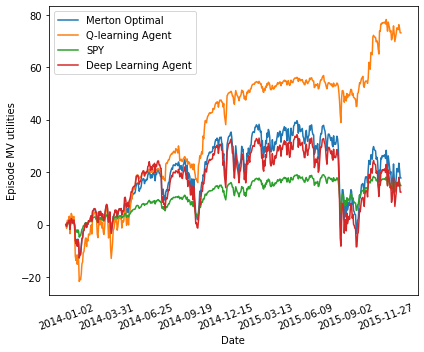

\begin{tabular}{lrrr}
\toprule
{} &  log utility &  mv utility &   wealth \\
\midrule
Merton        &        4.836 &      17.770 &  125.997 \\
Q-learning    &        5.185 &      73.136 &  178.519 \\
S\&P 500       &        4.754 &      14.879 &  115.995 \\
Deep Learning &        4.796 &      12.357 &  121.030 \\
\bottomrule
\end{tabular}



In [73]:
%store -r period_1
sp500_plt_tabl('2014-01-01','2015-12-31', period_1, ticker='SPY')

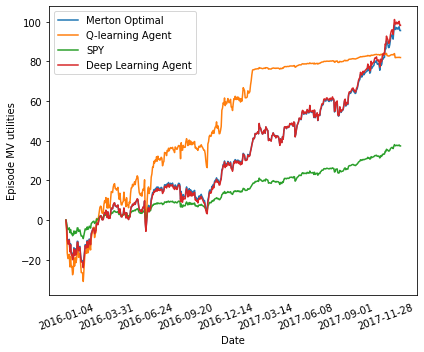

\begin{tabular}{lrrr}
\toprule
{} &  log utility &  mv utility &   wealth \\
\midrule
Merton        &        5.299 &      95.567 &  200.069 \\
Q-learning    &        5.238 &      81.971 &  188.286 \\
S\&P 500       &        4.927 &      37.395 &  138.007 \\
Deep Learning &        5.313 &      98.191 &  203.048 \\
\bottomrule
\end{tabular}



In [87]:
%store -r period_2
sp500_plt_tabl('2016-01-01','2017-12-31', period_2)

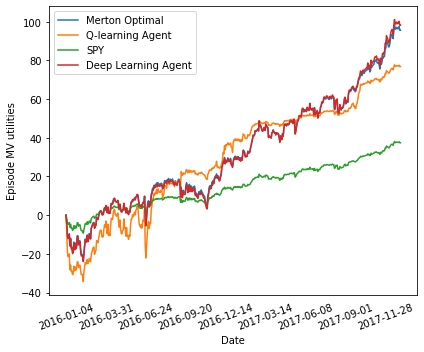

\begin{tabular}{lrrr}
\toprule
{} &  log utility &  mv utility &   wealth \\
\midrule
Merton        &        5.299 &      95.567 &  200.069 \\
Q-learning    &        5.203 &      76.821 &  181.820 \\
S\&P 500       &        4.927 &      37.396 &  138.007 \\
Deep Learning &        5.313 &      98.191 &  203.048 \\
\bottomrule
\end{tabular}



In [74]:
%store -r period_2
sp500_plt_tabl('2016-01-01','2017-12-31', period_2)

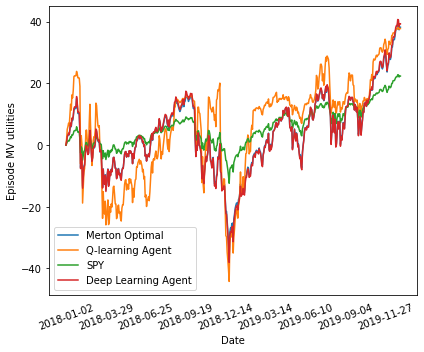

\begin{tabular}{lrrr}
\toprule
{} &  log utility &  mv utility &   wealth \\
\midrule
Merton        &        4.978 &      38.232 &  145.191 \\
Q-learning    &        5.029 &      37.787 &  152.824 \\
S\&P 500       &        4.817 &      22.385 &  123.557 \\
Deep Learning &        4.990 &      39.336 &  146.882 \\
\bottomrule
\end{tabular}



In [75]:
%store -r period_3
sp500_plt_tabl('2018-01-01','2019-12-31', period_3)

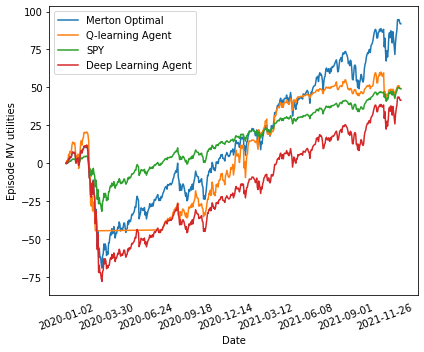

\begin{tabular}{lrrr}
\toprule
{} &  log utility &  mv utility &   wealth \\
\midrule
Merton        &        5.331 &      91.925 &  206.549 \\
Q-learning    &        5.068 &      49.298 &  158.854 \\
S\&P 500       &        5.024 &      49.146 &  152.067 \\
Deep Learning &        5.029 &      41.565 &  152.807 \\
\bottomrule
\end{tabular}



In [76]:
%store -r period_4
sp500_plt_tabl('2020-01-01','2021-12-31', period_4)

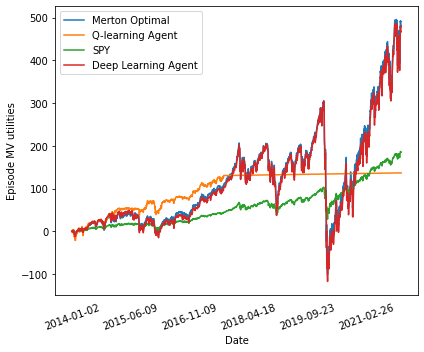

,log utility,mv utility,wealth
Merton,6.848,479.690,942.047
Q-learning,5.511,136.834,247.409
S&P 500,5.709,185.159,301.604
Deep Learning,6.858,466.628,951.382


In [33]:
%store -r period_5
sp500_plt_tabl('2014-01-01','2021-12-31', period_5)

In [49]:
ticker_list=list(pd.read_csv('/Users/madsrefer/Desktop/Specialeprojekt/Python/Thesis/MRes-Thesis/RL/nasdaq_screener.csv').Symbol)

In [50]:
def sp500_tabl(start, end, deep_data, tickerlist):
    ut_b,re_b,_,we_b,_=execute_strat_sp500(kappa, rf, sigma, utes,u_star,best_action, 'Merton', start=start, end=end, ticker=ticker,q_values=None,
                                                                        wealth=wealth, episodes=2) 

    ut_s,re_s,_,we_s,_=execute_strat_sp500(kappa, rf, sigma, utes,u_star,best_action, 'sp500', start=start, end=end,ticker=ticker,q_values=None,
                                                                        wealth=wealth, episodes=2)   
    ut_d,re_d,_,we_d,_=deep_data                                                                                                                                                                                                                
    for i in tickerlist:
        ut_a,re_a,_,we_a,_=execute_strat_sp500(kappa, rf, sigma, utes,u_star,best_action, 'Agent', start=start, end=end, ticker=i,q_values=Q,
                                                                    wealth=wealth, episodes=2)                                                                                
        df=pd.DataFrame([[ut_b,re_b,we_b],[ut_a,re_a,we_a],[ut_s,re_s,we_s], [ut_d,re_d,we_d]], columns=["log utility", "mv utility", "wealth"], index=['Merton','Q-learning','S&P 500','Deep Learning'])
        for i in ["log utility", "mv utility", "wealth"]:
            df[i] = df[i].str[0]   
        df=df.round(3)

    return df

In [219]:
pfew=execute_strat_sp500(kappa, rf, sigma, utes,u_star,best_action, 'sp500', start=start, end=end,ticker='PFE',q_values=None,
                                                                        wealth=wealth, episodes=2) 

In [140]:
start='2020-01-01'
end='2020-12-31'
ticker_list.remove('TSM')

In [141]:
merton_list=[]
agent_list=[]
one_list=[]
for i in ticker_list:
    print(i)
    merton_list.append(execute_strat_sp500(kappa, rf, sigma, utes,u_star,best_action, 'Merton', start=start, end=end, ticker=i,q_values=None,
                                                                    wealth=wealth, episodes=2))
    one_list.append(execute_strat_sp500(kappa, rf, sigma, utes,u_star,best_action, 'sp500', start=start, end=end,ticker=i,q_values=None,
                                                                    wealth=wealth, episodes=2))
    agent_list.append(execute_strat_sp500(kappa, rf, sigma, utes,u_star,best_action, 'Agent', start=start, end=end, ticker=i,q_values=Q,
                                                                wealth=wealth, episodes=2))
    

AAPL
ABBV
AMZN
ASML
AVGO
AZN
BABA
BAC
COST
CSCO
CVX
GEN
GOOG
GOOGL
HD
JNJ
JPM
KO
LLY
MA
MCD
META
MRK
MSFT
NVDA
NVO
ORCL
PEP
PFE
PG
SHEL
TMO
TSLA
UNH
XOM


In [248]:
wb.DataReader('CVX', data_source = 'yahoo', start = start, end=end)['Adj Close']

Date
2020-01-02    105.398476
2020-01-03    105.033928
2020-01-06    104.678055
2020-01-07    103.341362
2020-01-08    102.160919
                 ...    
2020-12-24     78.261154
2020-12-28     77.866776
2020-12-29     77.600792
2020-12-30     78.261154
2020-12-31     77.454056
Name: Adj Close, Length: 253, dtype: float64

In [144]:
merton_df=pd.DataFrame(merton_list, index=ticker_list)[1]
agent_df=pd.DataFrame(agent_list, index=ticker_list)[1]
one_df=pd.DataFrame(one_list, index=ticker_list)[1]
nasdaq_df=pd.DataFrame(d_naqdag_list, index=ticker_list)[1]

In [167]:
merton_df_w=pd.DataFrame(merton_list, index=ticker_list)[3]
agent_df_w=pd.DataFrame(agent_list, index=ticker_list)[3]
one_df_w=pd.DataFrame(one_list, index=ticker_list)[3]
nasdaq_df_w=pd.DataFrame(d_naqdag_list, index=ticker_list)[3]

In [235]:
concat_df_w=pd.concat([agent_df_w, merton_df_w,one_df_w,nasdaq_df_w], axis=1, join="inner")
concat_df_w.columns=['Q-learning','Merton','Stock','Q-network']
for i in concat_df_w.columns:
    concat_df_w[i] = concat_df_w[i].str[0]-100


In [236]:
concat_df_w['Winner']=concat_df_w.idxmax(axis=1)


In [239]:
print(pd.DataFrame(concat_df_w).round(2).to_latex())

\begin{tabular}{lrrrrl}
\toprule
{} &  Q-learning &   Merton &   Stock &  Q-network &      Winner \\
\midrule
AAPL  &      -42.87 &   167.00 &   79.99 &      74.90 &      Merton \\
ABBV  &      147.37 &    34.93 &   27.49 &      74.15 &  Q-learning \\
AMZN  &      149.39 &   180.89 &   73.71 &     -11.01 &      Merton \\
ASML  &      -40.36 &   102.12 &   65.16 &     167.60 &   Q-network \\
AVGO  &      -40.47 &    35.85 &   45.72 &     165.33 &   Q-network \\
AZN   &      -40.26 &   -22.48 &    2.65 &      28.76 &   Q-network \\
BABA  &       77.36 &   -20.50 &    7.25 &     -90.51 &  Q-learning \\
BAC   &      -46.72 &   -63.70 &  -10.82 &     138.00 &   Q-network \\
COST  &       83.24 &    64.82 &   33.66 &     149.12 &   Q-network \\
CSCO  &      -45.01 &   -39.27 &   -3.53 &     131.31 &   Q-network \\
CVX   &      -49.75 &   -80.37 &  -26.26 &      97.24 &   Q-network \\
GEN   &      148.81 &    74.15 &   42.62 &      43.86 &  Q-learning \\
GOOG  &      -45.47 &    32.17 &   28.

In [210]:
type(pd.DataFrame(concat_df_w[concat_df_w.index!='TSLA'].mean(axis=0)).T)

pandas.core.frame.DataFrame

In [241]:
print((pd.DataFrame(concat_df_w[concat_df_w.index!='TSLA'].mean(axis=0)).T).round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Q-learning &  Merton &  Stock &  Q-network \\
\midrule
0 &      -14.47 &   19.89 &  21.97 &     103.05 \\
\bottomrule
\end{tabular}



In [247]:
print(concat_df_w.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrl}
\toprule
{} &  Q-learning &  Merton &  Stock &  Q-network &      Winner \\
\midrule
AAPL  &      -42.87 &  167.00 &  79.99 &      74.90 &      Merton \\
ABBV  &      147.37 &   34.93 &  27.49 &      74.15 &  Q-learning \\
AMZN  &      149.39 &  180.89 &  73.71 &     -11.01 &      Merton \\
ASML  &      -40.36 &  102.12 &  65.16 &     167.60 &   Q-network \\
AVGO  &      -40.47 &   35.85 &  45.72 &     165.33 &   Q-network \\
AZN   &      -40.26 &  -22.48 &   2.65 &      28.76 &   Q-network \\
BABA  &       77.36 &  -20.50 &   7.25 &     -90.51 &  Q-learning \\
BAC   &      -46.72 &  -63.70 & -10.82 &     138.00 &   Q-network \\
COST  &       83.24 &   64.82 &  33.66 &     149.12 &   Q-network \\
CSCO  &      -45.01 &  -39.27 &  -3.53 &     131.31 &   Q-network \\
CVX   &      -49.75 &  -80.37 & -26.26 &      97.24 &   Q-network \\
GEN   &      148.81 &   74.15 &  42.62 &      43.86 &  Q-learning \\
GOOG  &      -45.47 &   32.17 &  28.75 &     201.16 &   Q-networ